In [44]:
import torch
import pandas as pd
from transformers import BertTokenizer
from torch.utils.data import TensorDataset, random_split
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
import numpy as np
import random

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [2]:
# # If there's a GPU available...
# if torch.cuda.is_available():    

#     # Tell PyTorch to use the GPU.    
#     device = torch.device("cuda")

#     print('We will use the GPU:', torch.cuda.get_device_name(0))

# # If not...
# else:
print('No GPU available, using the CPU instead.')
device = torch.device("cpu")

No GPU available, using the CPU instead.


In [3]:
DATA_FOLDER = "Data/Shared Task/eng/"
FILE_NAME = "trac2_eng_train.csv"

In [4]:
df = pd.read_csv(DATA_FOLDER+FILE_NAME)

In [5]:
print("Number of samples: ",df.shape[0])

Number of samples:  4263


In [6]:
df.sample(10)

,ID,Text,Sub-task A,Sub-task B
650,C4.152,This is soo true 💯💯💯💯💯❤ bhai..u are best..,NAG,NGEN
3739,C4.1086.5,You saved my dude bro😂😂😂😂🤣🤣🤣,NAG,NGEN
1099,C4.1372,if movies are like our real life why making mo...,CAG,GEN
4152,C59.163,Just mind blowing 👌,NAG,NGEN
2271,C33.617,wow nice video !!,NAG,NGEN
1141,C4.2109,Correct❤,NAG,NGEN
4043,C10.534,She can write her father name in npr ranga billa.,NAG,NGEN
3459,C7.1583,Haha what a joke..u should not speak dude,NAG,NGEN
3918,C68.402,Ranu.nice,NAG,NGEN
488,C59.1201,Love you vaiya nice video.i love you,NAG,NGEN


In [7]:
sentences = df.Text.values
labels = df['Sub-task B'].values

In [8]:
labels[0:10]

array(['NGEN', 'NGEN', 'NGEN', 'NGEN', 'NGEN', 'NGEN', 'NGEN', 'NGEN',
       'NGEN', 'NGEN'], dtype=object)

We will need to convert labels into 0s and 1s as model cannot take string input
- 0: NGEN
- 1: GEN

In [9]:
labels_int=[]

In [10]:
for label in labels:
    if(label=='NGEN'): 
        labels_int.append(0)
    else:
        labels_int.append(1)

In [11]:
labels = labels_int

## Data Description
Sub-Task 2 is related to Misogyny detection
- GEN: Gendered or Misogynous
- NGEN: Non-gendered or Non-Misogynous

In [12]:
df['Sub-task B'].unique()

array(['NGEN', 'GEN'], dtype=object)

## Tokenisation

In [13]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

In [14]:
# Print the original sentence.
print(' Original: ', sentences[10])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[10]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[10])))

 Original:  Hindi old muvi
Tokenized:  ['Hindi', 'old', 'mu', '##vi']
Token IDs:  [31341, 12898, 12361, 11310]


### Trying  tokenisation with emojis

In [15]:
# Print the original sentence.
print(' Original: ', sentences[2867])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[2867]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[2867])))

 Original:  Megha here 😂😂
Tokenized:  ['Meg', '##ha', 'here', '[UNK]']
Token IDs:  [77499, 10921, 19353, 100]


Removing them is better. But let's get a baseline result with them too.

## Formatting input
We are required to:

1. Add special tokens to the start and end of each sentence.
2. Pad & truncate all sentences to a single constant length.
3. Explicitly differentiate real tokens from padding tokens with the “attention mask”.

I am taking 100 as max length. Look at  `Visualising Data Notebook` for details

In [16]:
MAX_LEN = 100 

The tokenizer.encode_plus function combines multiple steps for us:

1. Split the sentence into tokens.
2. Add the special [CLS] and [SEP] tokens.
3. Map the tokens to their IDs.
4. Pad or truncate all sentences to the same length.
5. Create the attention masks which explicitly differentiate real tokens from [PAD] tokens.

In [17]:
input_ids = []
attention_masks = []
# The “Attention Mask” is simply an array of 1s and 0s indicating
# which tokens are padding and which aren’t

In [18]:
for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                    sent,
                    add_special_tokens =True, # for [CLS] and [SEP]
                    max_length = MAX_LEN,
                    truncation = True,
                    padding = 'max_length',
                    return_attention_mask = True,
                    return_tensors = 'pt', # return pytorch tensors
    )
    input_ids.append(encoded_dict['input_ids'])
    
    attention_masks.append(encoded_dict['attention_mask'])

In [19]:
import copy

input_ids_copy = copy.deepcopy(input_ids)
attention_masks_copy = copy.deepcopy(attention_masks)
labels_copy = copy.deepcopy(labels)

In [20]:
input_ids = input_ids_copy
attention_masks = attention_masks_copy
labels = labels_copy

In [21]:
# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[10])
print('Token IDs:', input_ids[10])

Original:  Hindi old muvi
Token IDs: tensor([  101, 31341, 12898, 12361, 11310,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])


In [22]:
input_ids.shape,attention_masks.shape,labels.shape

(torch.Size([4263, 100]), torch.Size([4263, 100]), torch.Size([4263]))

## Train Validation Split

In [23]:
dataset = TensorDataset(input_ids, attention_masks, labels)

In [24]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

In [25]:
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

3,410 training samples
  853 validation samples


## Data Loader

In [26]:
BATCH_SIZE = 32

In [27]:
# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = BATCH_SIZE # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = BATCH_SIZE # Evaluate with this batch size.
        )

## Training

In [28]:
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-multilingual-cased", 
    num_labels = 2, # The number of output labels--2 for binary classification.  
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

In [29]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [30]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (119547, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              

## Optimiser and Learning Rate Scheduler

In [31]:
LR = 2e-5 # other options 5e-5,3e-5
EPOCHS = 4 # other options 2,3

In [32]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, 
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [33]:
total_steps = len(train_dataloader) * EPOCHS

In [34]:
scheduler = get_linear_schedule_with_warmup(optimizer, 
                num_warmup_steps = 0, # Default value in run_glue.py
                num_training_steps = total_steps)

## Training Loop

### Training:

- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Clear out the gradients calculated in the previous pass.
    -In pytorch the gradients accumulate by default (useful for things like RNNs) unless you explicitly clear them out.
- Forward pass (feed input data through the network)
- Backward pass (backpropagation)
- Tell the network to update parameters with optimizer.step()
- Track variables for monitoring progress

### Evalution:

- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Forward pass (feed input data through the network)
- Compute loss on our validation data and track variables for monitoring progress

In [35]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

This training code is based on the `run_glue.py` script here:
https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

In [36]:
# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [37]:
training_stats = []

In [ ]:
for epoch_i in range(0, EPOCHS):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, EPOCHS))
    print('Training...')
    
    total_train_loss = 0
    
    model.train()  # set the model to training mode
    
    for step, batch in enumerate(train_dataloader):
        if step % 40 == 0 and not step == 0:
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
    
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        model.zero_grad() 
        
        outputs = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        
        loss = outputs[0]
        
        total_train_loss += loss.item()
        
        loss.backward() # perform a backward pass
        
        # clip graidents to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        
        scheduler.step()
    
    avg_train_loss = total_train_loss / len(train_dataloader)
    
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    
    print("")
    print("Running Validation...") 
    
    model.eval() # put model in eval mode
    
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    
    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad(): # do not construct compute graph
            outputs = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
        
        loss = outputs[0]
        logits = outputs[1]
        total_eval_loss += loss.item()
        
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
        }
    )
    
print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...


In [39]:
pd.set_option('precision', 2)

In [40]:
df_stats = pd.DataFrame(data=training_stats)

In [41]:
df_stats = df_stats.set_index('epoch')

In [42]:
df_stats

,Training Loss,Valid. Loss,Valid. Accur.
epoch,,,
1,0.25,0.21,0.92
2,0.18,0.20,0.93
3,0.12,0.28,0.90
4,0.09,0.29,0.92


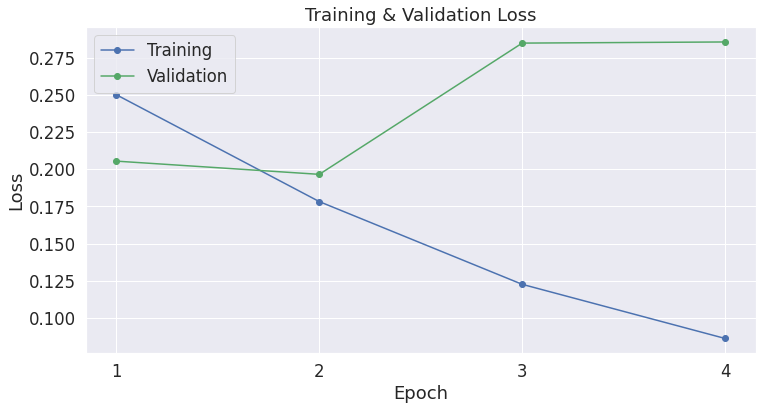

In [46]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

## Final Code

In [51]:
# Core
import random

# Basics
import numpy as np
import pandas as pd
import torch

# Metrics
from sklearn.metrics import *

# Tokeniser
from transformers import BertTokenizer

# Utility
from tqdm import tqdm

# Dataloader
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Scheduler
from transformers import get_linear_schedule_with_warmup

# Optimiser
from transformers import AdamW

# Model
from transformers import BertForSequenceClassification
import torch.nn as nn

In [55]:
class BERT:
    def __init__(self,args):
        # fix the random
        random.seed(args['seed_val'])
        np.random.seed(args['seed_val'])
        torch.manual_seed(args['seed_val'])
        torch.cuda.manual_seed_all(args['seed_val'])
                
        self.device = torch.device(args['device'])
        self.weights=args['weights']
        
        self.tokenizer = BertTokenizer.from_pretrained(args['bert_model'])
        
    ##-----------------------------------------------------------##
    ##----------------- Utility Functions -----------------------##
    ##-----------------------------------------------------------##
    def encode(self,data,max_len):
        
        input_ids = []
        attention_masks = []
        for sent in tqdm(data):
            encoded_dict = self.tokenizer.encode_plus(
                            sent,
                            add_special_tokens =True, # for [CLS] and [SEP]
                            max_length = max_len,
                            truncation = True,
                            padding = 'max_length',
                            return_attention_mask = True,
                            return_tensors = 'pt', # return pytorch tensors
            )
            input_ids.append(encoded_dict['input_ids'])

            attention_masks.append(encoded_dict['attention_mask'])
        
        return [input_ids,attention_masks]
    
    ##-----------------------------------------------------------##
    ##------------------ Dataloader -----------------------------##
    ##-----------------------------------------------------------##
    def get_dataloader(self,samples, batch_size,is_train=False):
        inputs,masks,labels = samples

        # Convert the lists into tensors.
        inputs = torch.cat(inputs, dim=0)
        masks = torch.cat(masks, dim=0)
        labels = torch.tensor(labels)

        data = TensorDataset(inputs,masks,labels)

        if(is_train==False):
            sampler = SequentialSampler(data)
        else:
            sampler = RandomSampler(data)  

        dataloader = DataLoader(data, sampler=sampler, batch_size=batch_size)

        return dataloader
    
    ##-----------------------------------------------------------##
    ##----------------- Training Utilities ----------------------##
    ##-----------------------------------------------------------## 
    def get_optimiser(self,learning_rate,model):
        return AdamW(model.parameters(),
                  lr = learning_rate, 
                  eps = 1e-8
                )
    
    def get_scheduler(self,epochs,optimiser,train_dl):
        total_steps = len(train_dl) * epochs
        return get_linear_schedule_with_warmup(optimiser, 
                num_warmup_steps = 0, # Default value in run_glue.py
                num_training_steps = total_steps)
    
    def evalMetric(self,y_true, y_pred,prefix):
        accuracy = accuracy_score(y_true, y_pred)
        mf1Score = f1_score(y_true, y_pred, average='macro')
        f1Score  = f1_score(y_true, y_pred, labels = np.unique(y_pred))
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        area_under_c = auc(fpr, tpr)
        recallScore = recall_score(y_true, y_pred, labels = np.unique(y_pred))
        precisionScore = precision_score(y_true, y_pred, labels = np.unique(y_pred))
        return dict({prefix+"accuracy": accuracy, prefix+'mF1Score': mf1Score, 
                        prefix+'f1Score': f1Score, prefix+'precision': precisionScore, 
                        prefix+'recall': recallScore})
    
    ##-----------------------------------------------------------##
    ##---------------- Different Train Loops --------------------##
    ##-----------------------------------------------------------## 
    def evaluate(self,model,loader,which):
    
        model.eval() # put model in eval mode

        total_eval_loss = 0
        nb_eval_steps = 0

        y_pred = np.zeros(shape=(0),dtype='int')
        y_true = np.empty(shape=(0),dtype='int')

        for batch in loader:
            b_input_ids = batch[0].to(self.device)
            b_input_mask = batch[1].to(self.device)
            b_labels = batch[2].to(self.device)

            with torch.no_grad(): # do not construct compute graph
                outputs = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)

            loss = outputs[0]
            logits = outputs[1]

            total_eval_loss += loss.item()

            b_y_true = b_labels.cpu().data.squeeze().numpy()

            b_y_pred = torch.max(logits,1)[1]
            b_y_pred = b_y_pred.cpu().data.squeeze().numpy()

            y_pred = np.concatenate((y_pred,b_y_pred))
            y_true = np.concatenate((y_true,b_y_true))

        metrics = self.evalMetric(y_true,y_pred,which+"_")

        # Calculate the average loss over all of the batches.
        avg_loss = total_eval_loss / len(loader)

        metrics[which+'_avg_loss'] = avg_loss

        return metrics
    
    
    def run_train_loop(self,model,train_loader,optimiser,scheduler):
        
        total_loss = 0
        model.train() # put model in train mode

        y_pred = np.zeros(shape=(0),dtype='int')
        y_true = np.empty(shape=(0),dtype='int')

        for step, batch in tqdm(enumerate(train_loader)):

            b_input_ids = batch[0].to(self.device)
            b_input_mask = batch[1].to(self.device)
            b_labels = batch[2].to(self.device)

            model.zero_grad()        

            outputs = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

            logits = outputs[1]

            loss_fct = nn.CrossEntropyLoss(weight=torch.tensor(
                        self.weights,dtype=torch.float))
            
            loss = loss_fct(logits,b_labels)
            
            total_loss += loss.item()

            loss.backward()

            b_y_true = b_labels.cpu().data.squeeze().numpy()

            b_y_pred = torch.max(logits,1)[1]
            b_y_pred = b_y_pred.cpu().data.squeeze().numpy()

            y_pred = np.concatenate((y_pred,b_y_pred))
            y_true = np.concatenate((y_true,b_y_true))

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimiser.step()
            
            scheduler.step()

        avg_train_loss = total_loss / len(train_loader)

        train_metrics = self.evalMetric(y_true,y_pred,"Train_")

        print('avg_train_loss',avg_train_loss)
        print('train_f1Score',train_metrics['Train_f1Score'])
        print('train_accuracy',train_metrics['Train_accuracy'])

        train_metrics['Train_avg_loss'] = avg_train_loss

        return train_metrics
    
    
    ##------------------------------------------------------------##
    ##----------------- Main Train Loop --------------------------##
    ##------------------------------------------------------------##
    def train(self,model,data_loaders,optimiser,scheduler,epochs):
        train_stats = []
        train_loader,val_loader,test_loader = data_loaders
        for epoch_i in range(0, epochs):
            print("")
            print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
            
            print("")
            print('Training...')
            train_metrics = self.run_train_loop(model,train_loader,
                                            optimiser,scheduler)

            print("")
            print("Running Validation...") 
            val_metrics = self.evaluate(model,val_loader,"Val")
            
            print("Validation Loss: ",val_metrics['Val_avg_loss'])
            print("Validation Accuracy: ",val_metrics['Val_accuracy'])
            
            stats = {}

            stats['epoch']=epoch_i+1

            stats.update(train_metrics)
            stats.update(val_metrics)

            train_stats.append(stats)

        return train_stats
    
    ##-----------------------------------------------------------##
    ##----------------------- Main Pipeline ---------------------##
    ##-----------------------------------------------------------##
    def run(self,args,df_train,df_val,df_test):
        X_train = df_train['Text'].values
        Y_train = df_train['Label'].values
        X_test = df_test['Text'].values
        Y_test = df_test['Label'].values
        X_val = df_val['Text'].values
        Y_val = df_val['Label'].values
        
        train_data = self.encode(X_train,args['max_len'])
        val_data = self.encode(X_val,args['max_len'])
        test_data = self.encode(X_test,args['max_len'])
        
        train_data.append(Y_train)
        val_data.append(Y_val)
        test_data.append(Y_test)
        
        train_dl =self.get_dataloader(train_data,args['batch_size'],True)
        val_dl =self.get_dataloader(val_data,args['batch_size'])                          
        test_dl =self.get_dataloader(test_data,args['batch_size'])
        
        model = BertForSequenceClassification.from_pretrained(
                args['bert_model'], 
                num_labels = 2, 
                output_attentions = False, # Whether the model returns attentions weights.
                output_hidden_states = False, # Whether the model returns all hidden-states.
            )
        
        optimiser = self.get_optimiser(args['learning_rate'],model)
        
        scheduler = self.get_scheduler(args['epochs'],optimiser,train_dl)
        
        train_stats = self.train(model,[train_dl,val_dl,test_dl],
                                optimiser,scheduler,args['epochs'])
        
        return train_stats
        

In [7]:
DATA_FOLDER = "Data_Processed/Shared_Task_eng/"

df_train = pd.read_csv(DATA_FOLDER+"train_1.csv")
df_val = pd.read_csv(DATA_FOLDER+"val_1.csv")
df_test = pd.read_csv(DATA_FOLDER+"test_1.csv")

df_train.dropna(inplace=True)
df_val.dropna(inplace=True)
df_test.dropna(inplace=True)

In [38]:
df_train=df_train.iloc[0:128]
df_val=df_val.iloc[0:32]
df_test=df_test.iloc[0:32]

In [47]:
args={
    'seed_val': 42,
    'batch_size':32,
    'bert_model': "bert-base-multilingual-cased",
    'learning_rate': 2e-5,
    'epochs': 4,
    'max_len': 100,
    'device': 'cpu',
    'weights':[1.0,5.0]
}

In [56]:
bert = BERT(args)

In [57]:
bert.run(args,df_train,df_val,df_test)

100%|██████████| 32/32 [00:00<00:00, 1855.42it/s]
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceCla


======== Epoch 1 / 4 ========

Training...


4it [00:21,  5.37s/it]


avg_train_loss 0.6627405136823654
train_f1Score 0.20833333333333334
train_accuracy 0.703125

Running Validation...


0it [00:00, ?it/s]

Validation Loss:  0.5316233038902283
Validation Accuracy:  0.6875

======== Epoch 2 / 4 ========

Training...


4it [00:20,  5.02s/it]


avg_train_loss 0.5979474037885666
train_f1Score 0.23999999999999996
train_accuracy 0.8515625

Running Validation...


0it [00:00, ?it/s]

Validation Loss:  0.3841923475265503
Validation Accuracy:  0.9375

======== Epoch 3 / 4 ========

Training...


4it [00:21,  5.43s/it]


avg_train_loss 0.5398473590612411
train_f1Score 0.39999999999999997
train_accuracy 0.9296875

Running Validation...


0it [00:00, ?it/s]

Validation Loss:  0.3392186760902405
Validation Accuracy:  0.9375

======== Epoch 4 / 4 ========

Training...


4it [00:20,  5.23s/it]


avg_train_loss 0.5437285602092743
train_f1Score 0.3076923076923077
train_accuracy 0.9296875

Running Validation...
Validation Loss:  0.33620166778564453
Validation Accuracy:  0.9375


[{'epoch': 1,
  'Train_accuracy': 0.703125,
  'Train_mF1Score': 0.5128205128205129,
  'Train_f1Score': 0.20833333333333334,
  'Train_precision': 0.13513513513513514,
  'Train_recall': 0.45454545454545453,
  'Train_avg_loss': 0.6627405136823654,
  'Val_accuracy': 0.6875,
  'Val_mF1Score': 0.5428571428571429,
  'Val_f1Score': 0.2857142857142857,
  'Val_precision': 0.16666666666666666,
  'Val_recall': 1.0,
  'Val_avg_loss': 0.5316233038902283},
 {'epoch': 2,
  'Train_accuracy': 0.8515625,
  'Train_mF1Score': 0.5788744588744589,
  'Train_f1Score': 0.23999999999999996,
  'Train_precision': 0.21428571428571427,
  'Train_recall': 0.2727272727272727,
  'Train_avg_loss': 0.5979474037885666,
  'Val_accuracy': 0.9375,
  'Val_mF1Score': 0.4838709677419355,
  'Val_f1Score': 0.0,
  'Val_precision': 0.0,
  'Val_recall': 0.0,
  'Val_avg_loss': 0.3841923475265503},
 {'epoch': 3,
  'Train_accuracy': 0.9296875,
  'Train_mF1Score': 0.6813278008298754,
  'Train_f1Score': 0.39999999999999997,
  'Train_preci